In [43]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils
import matplotlib.pyplot as plt
import seaborn as sns

# Split the Data

In [2]:
# Directories containing preprocessed images
save_directory_real = '../data/interim/face_processed/real'
save_directory_fake = '../data/interim/face_processed/fake'

# Function to create a DataFrame with image paths and labels
# Changing labelling to be 1 if fake and 0 if real
def create_image_label_df(real_dir, fake_dir):
    real_images = [(os.path.join(real_dir, f), 0) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
    fake_images = [(os.path.join(fake_dir, f), 1) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
    
    # Combine real and fake images into one DataFrame
    df = pd.DataFrame(real_images + fake_images, columns=['image_path', 'label'])
    return df

# Create the DataFrame
images_df = create_image_label_df(save_directory_real, save_directory_fake)

In [3]:
# Splitting the data into features and target arrays
X = images_df['image_path'].values
y = images_df['label'].values

# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Second split to separate out the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

'''
Training Set: 60% of the original dataset.
Validation Set: 20% of the original dataset.
Testing Set: 20% of the original dataset.
'''

Training set size: 2400
Validation set size: 800
Testing set size: 800


'\nTraining Set: 60% of the original dataset.\nValidation Set: 20% of the original dataset.\nTesting Set: 20% of the original dataset.\n'

In [10]:
def load_images(image_paths, labels):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(128, 128), color_mode='grayscale') #Note: gray scale and size pre-processed alr
        img_array = img_to_array(img)/255.0 #Convert image to array + normalise 
        images.append(img_array) 
    return np.array(images), np.array(labels)

# Load and get images in dataset (From path)
X_train_processed, y_train_processed = load_images(X_train, y_train)
X_val_processed, y_val_processed = load_images(X_val, y_val)
X_test_processed, y_test_processed = load_images(X_test, y_test)

In [31]:
X_train_processed.shape
X_val_processed.shape

(800, 128, 128, 1)

# Data augmentation with data generators on grayscaled data

# Modelling

- Base with data generator (grayscaled preprocessed)

In [73]:
train_datagen = ImageDataGenerator(rotation_range=8, 
                         width_shift_range=0.08, 
                         shear_range=0.3,
                         height_shift_range=0.08, 
                         zoom_range=0.08,
                         fill_mode='nearest')

train_data = train_datagen.flow(X_train_processed, y_train_processed,shuffle=True)
validation = train_datagen.flow(X_val_processed, y_val_processed, shuffle=True)
test_data = train_datagen.flow(X_test_processed,y_test_processed, shuffle=True)

In [64]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

callbacks_list = [
    EarlyStopping(patience=5,
                  restore_best_weights=True),
    ReduceLROnPlateau(patience=2,
                      factor=0.5,
                      min_lr = 0.00001,
                      verbose = 1)
]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 14, 14, 128)     

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
mod_hist = model.fit(train_data,
                     epochs=20,
                     batch_size=32,
                     validation_data=validation, 
                     callbacks=callbacks_list)

Epoch 1/20
75/75 [==============================] - 30s 397ms/step - loss: 0.6945 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 30s 401ms/step - loss: 0.6935 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.4913 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 29s 392ms/step - loss: 0.6935 - accuracy: 0.4883 - val_loss: 0.6927 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 31s 412ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.6870 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 35s 474ms/step - loss: 0.6824 - accuracy: 0.5608 - val_loss: 0.6850 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 31s 409ms/step - loss: 0.6795 - accuracy: 0.5758 - val_loss: 0.6723 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 28s 374ms/st

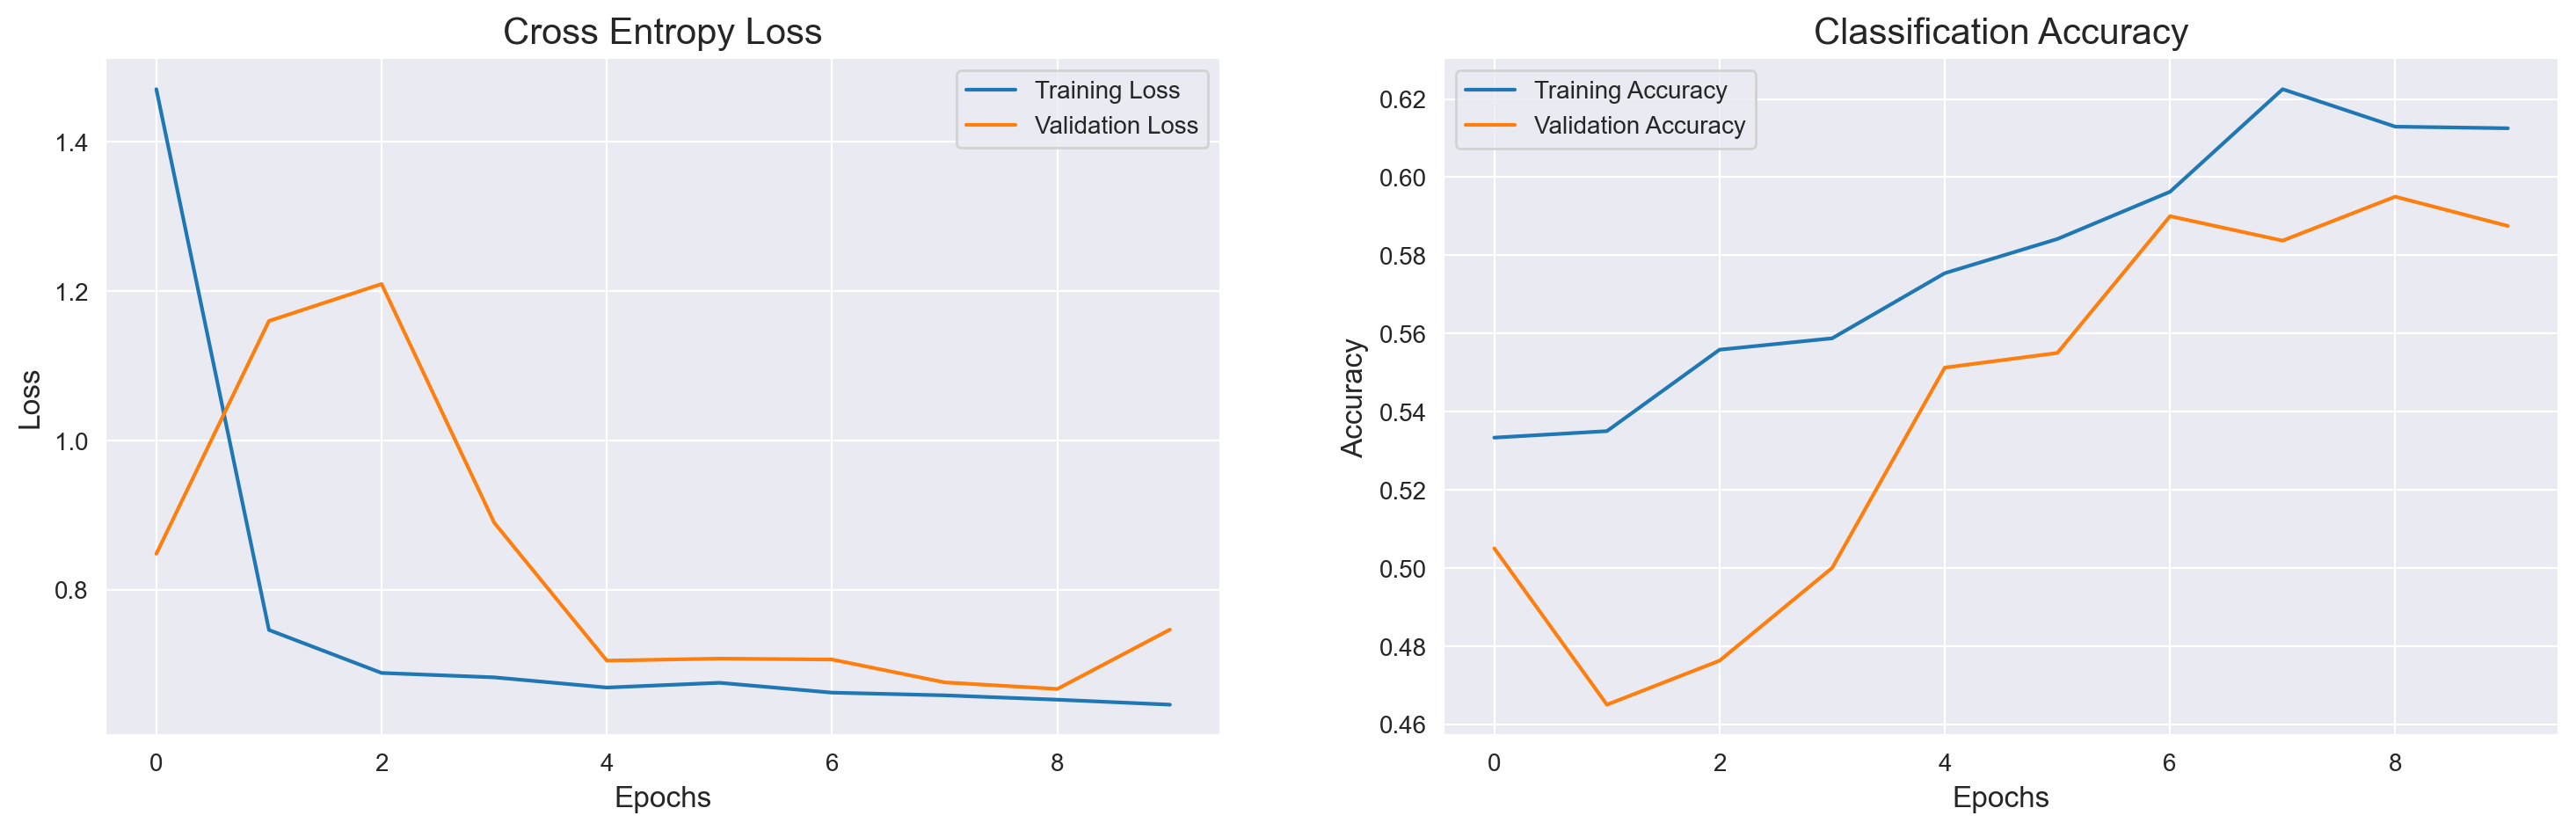

In [68]:
# plots for accuracy and Loss with epochs
plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'], label='Training Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'], label='Training Accuracy')
plt.plot(error['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [75]:
loss, accuracy = model.evaluate(test_data)
print(accuracy)

25/25 [==============================] - 1s 50ms/step - loss: 0.4827 - accuracy: 0.7738
0.7737500071525574


In [76]:
#Classes: fake == 1, real==0
predictions = model.predict(X_test_processed)
y_probab = predictions[:, 0]  # Assuming predictions.shape = (n_samples, 1)
print(y_probab)

25/25 [==============================] - 1s 48ms/step
[6.89122200e-01 9.28517342e-01 2.86321819e-01 6.01574242e-01
 9.99908090e-01 9.58728790e-01 7.32945561e-01 7.05228925e-01
 4.09051865e-01 9.35330927e-01 1.92628980e-01 3.42311233e-01
 9.65255424e-02 8.95307958e-02 7.83593431e-02 9.36004102e-01
 9.67667878e-01 4.02120084e-01 6.20168090e-01 1.72337085e-01
 3.84416580e-01 8.75153005e-01 6.00161552e-01 4.18528110e-01
 7.91942477e-01 6.54394254e-02 4.40408826e-01 3.50212693e-01
 2.55771130e-01 9.96120632e-01 4.24837232e-01 9.71382141e-01
 7.19673038e-01 5.16707838e-01 7.77273238e-01 2.43588462e-01
 7.07174540e-01 6.65665805e-01 7.12299049e-01 9.82483804e-01
 8.11904073e-01 4.37929034e-01 7.43773639e-01 2.16617703e-01
 6.89756751e-01 8.88089895e-01 2.19248049e-02 5.77722907e-01
 4.84974086e-01 9.14006591e-01 3.32216173e-01 9.61656392e-01
 9.69524682e-01 7.76981235e-01 2.49478668e-01 9.91699219e-01
 6.10797882e-01 7.16022134e-01 8.65389407e-01 8.83776695e-02
 2.78146923e-01 2.32702807e-01 